The aim of this notebook is to go through all the commonest techniques in participating in a Kaggle competition. The dataset used in this notebook is from the Kaggle competition [Titanic: Machine Learning from Disaster]( https://www.kaggle.com/c/titanic).

I'm still a beginner, so any advice or suggestion is well accepted!

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

RANDOM_SEED = 4321
np.random.seed = RANDOM_SEED

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Importing the dataset
--

We import the train and test csv file:

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.info()
train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


As for the training, we can see that there are some people with an empty age. The Cabin column is at most empty and only 2 entries have a missing Embarked feature.

Let us consider the test set:

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Also the test set has similar properties of the training test. We will deal with missing values later.

Let us explore the dataset a bit:

## Survivals

As we can expect, most of the people abroad did not survive.

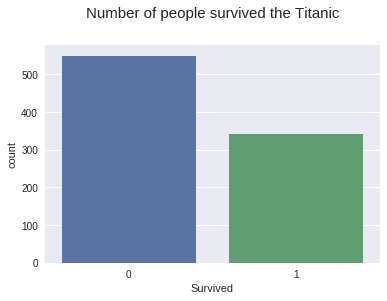

In [5]:
plt.title('Number of people survived the Titanic', y=1.1, size=15)
sns.countplot('Survived', data=train)

## Sex:

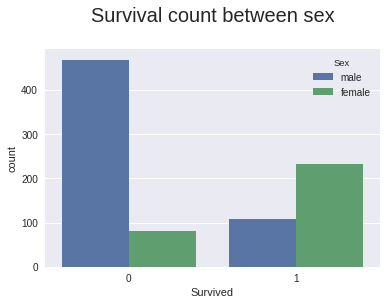

In [6]:
plt.title('Survival count between sex', size=20, y=1.1)
sns.countplot(x = 'Survived', hue='Sex', data=train)

So we can see that most of the survived people were women. Let's also analyze the survival rate:

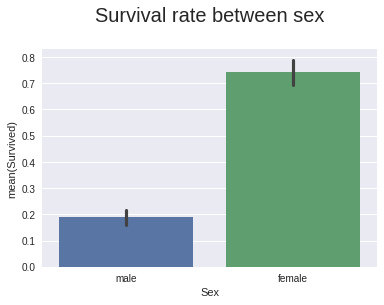

In [8]:
plt.title('Survival rate between sex', size=20, y=1.1)
sns.barplot(x='Sex', y='Survived', data=train)

Since we must deal with numerical feature, we should convert male/female in a binary vector 0/1.

In [9]:
for df in [train, test]:
    df['Sex'] = df['Sex'].apply(lambda x : 1 if x == 'male' else 0)

So females has an overall higher chance to survive.

## PClass:

Now let's analyze the Pclass feature:

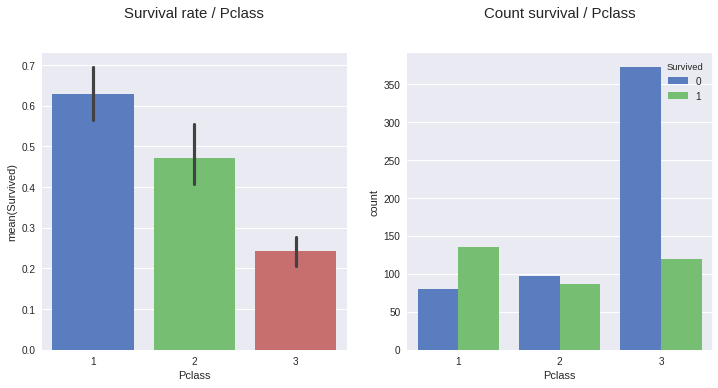

In [10]:
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.title('Survival rate / Pclass', size=15, y=1.1)
sns.barplot(x='Pclass', y = 'Survived', data=train, palette='muted')
plt.subplot(2,2,2)
plt.title('Count survival / Pclass', size=15, y=1.1)
sns.countplot(x='Pclass', hue = 'Survived', data=train, palette='muted')

## Embarked

Now let's dive into the embarked feature

In [11]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,NaN,C


count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

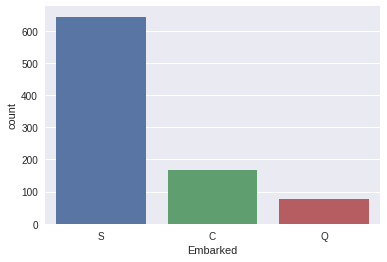

In [12]:
sns.countplot(train['Embarked'])
train['Embarked'].describe()

It seems that most of the people embarked in Southampton. Since it is the most frequent, we will fill the two missing values with 'S'

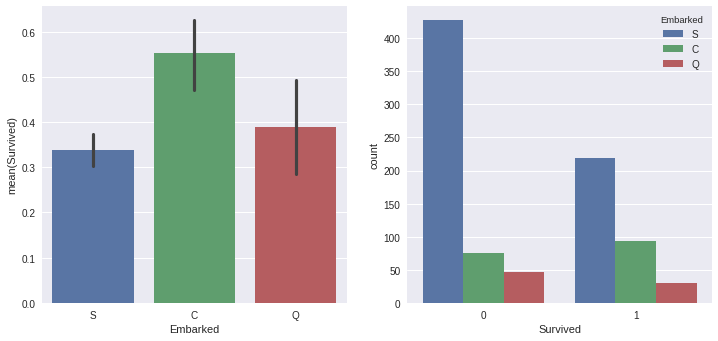

In [13]:
train['Embarked'] = train['Embarked'].fillna('S')
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
sns.barplot(y='Survived', x='Embarked', data=train)
plt.subplot(2,2,2)
sns.countplot(x='Survived', hue='Embarked', data=train)

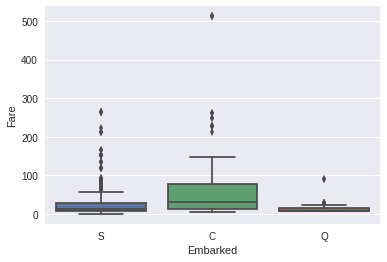

In [14]:
sns.boxplot(x='Embarked', y='Fare', data=train)

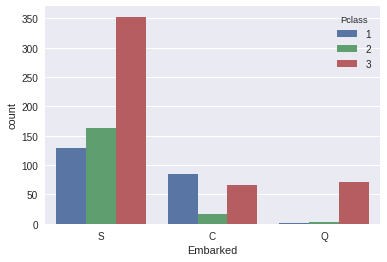

In [15]:
sns.countplot(hue='Pclass', x='Embarked', data=train)

There is a little correlation between the embarkment harbor and the survival rate. 

Since we want a numerical feature, we will convert the embarked in one hot vector

In [16]:
train = pd.get_dummies(train, columns=['Embarked'])
test = pd.get_dummies(test, columns=['Embarked'])

## Fare

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

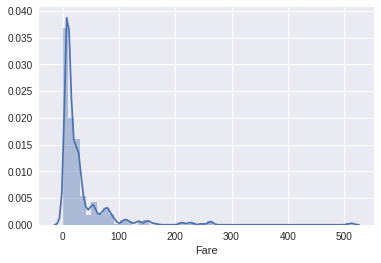

In [17]:
sns.distplot(train['Fare'])
train['Fare'].describe()

Fare is really right skewed (few people paying a very high fare and most people paying a low fare). We can see that in the train we have all the values, but one value is missing in test set. Fill it with the median:

In [19]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

Since the fare is so oddly distributed, is seems reasonable to introduce categories:

In [20]:
for df in [train, test]:
    df['Fare'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3])

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0,NaN,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,3,C85,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,1,NaN,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3,C123,0.0,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,1,NaN,0.0,0.0,1.0


## Cabin

Cabin is a feature that has very few non null entries. Thus, we can drop this column and only take into account whether the value was present or not.

In [21]:
for df in [train, test]:
    df['Cabin'] = df['Cabin'].fillna('NaN')
    df['HasCabin'] = df['Cabin'].apply(lambda x : 0 if x == 'NaN' else 1)

train, test = train.drop(['Cabin'], axis=1), test.drop(['Cabin'], axis=1)

## Parch and SibSp

**Parch** is the abbreviation of 'parent/children' and represent the sum of parents and children.

**SibSp** is the abbreviation of 'sibling/spouse' and represent the sum of brothers/sisters/wife/husband.

This said, we can compute the family size as the sum of the two above + 1

In [22]:
for df in [train, test]:
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

We have also added a feature TravelAlone, this is to say if the passenger has some family member on board or not.

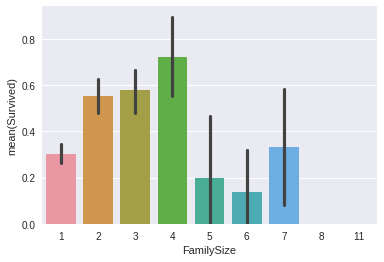

In [23]:
sns.barplot(x='FamilySize', y='Survived' , data=train)

Those with 2-4 family members had a slightly more chance to survive

In [24]:
def filter_family_size(x):
    if x == 1:
        return 'Solo'
    elif x < 4:
        return 'Small'
    else:
        return 'Big'

for df in [train, test]:
    df['FamilySize'] = df['FamilySize'].apply(filter_family_size)

train = pd.get_dummies(train, columns=['FamilySize'])
test = pd.get_dummies(test, columns=['FamilySize'])

## Name

Let's see if we can extract something from the name. Here is a list of names from the dataset:

In [25]:
train['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

One thing that can be useful is the title, which can be found soon after the first comma. Since there are a lot of rare titles, we will join the uncommon ones (such as countess, dona, jonkeer, ...) in 6 labels

In [28]:
# Filter the name
def get_title(x):
    y = x[x.find(',')+1:].replace('.', '').replace(',', '').strip().split(' ')
    if y[0] == 'the':    # Search for the countess
        title = y[1]
    else:
        title = y[0]
    return title

def filter_title(title, sex):
    if title in ['Countess', 'Dona', 'Lady', 'Jonkheer', 'Mme', 'Mlle', 'Ms', 'Capt', 'Col', 'Don', 'Sir', 'Major', 'Rev', 'Dr']:
        if sex:
            return 'Rare_male'
        else:
            return 'Rare_female'
    else:
        return title

for df in [train, test]:
    df['NameLength'] = df['Name'].apply(lambda x : len(x))
    df['Title'] = df['Name'].apply(get_title)
    
train.groupby('Title')['PassengerId'].count().sort_values(ascending=False)

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Countess      1
Don           1
Sir           1
Jonkheer      1
Lady          1
Mme           1
Ms            1
Capt          1
Name: PassengerId, dtype: int64

In [29]:
for df in [train, test]:
    df['Title'] = df.apply(lambda x: filter_title(x['Title'], x['Sex']), axis=1)

In [30]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_C,Embarked_Q,Embarked_S,HasCabin,FamilySize_Big,FamilySize_Small,FamilySize_Solo,NameLength,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0,0.0,0.0,1.0,0,0.0,1.0,0.0,23,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,3,1.0,0.0,0.0,1,0.0,1.0,0.0,51,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,1,0.0,0.0,1.0,0,0.0,0.0,1.0,22,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3,0.0,0.0,1.0,1,0.0,1.0,0.0,44,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,1,0.0,0.0,1.0,0,0.0,0.0,1.0,24,Mr


Title
Mr             517
Miss           182
Mrs            125
Master          40
Rare_male       20
Rare_female      7
Name: PassengerId, dtype: int64

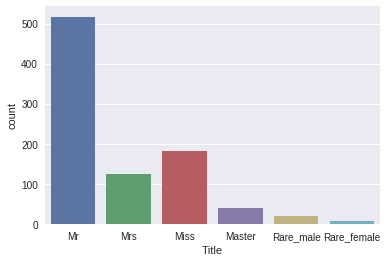

In [32]:
sns.countplot(x=train['Title'])
train.groupby('Title')['PassengerId'].count().sort_values(ascending=False)

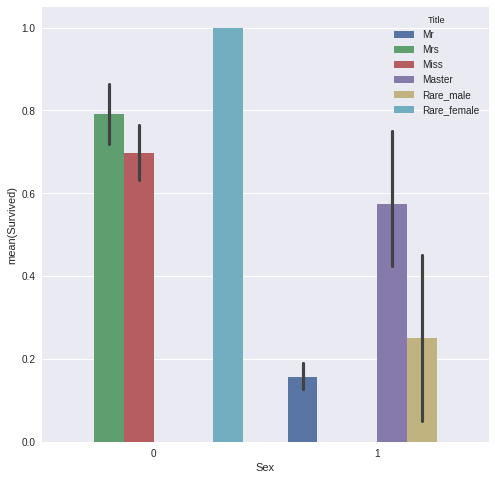

In [33]:
plt.figure(figsize=(8, 8))
sns.barplot(x='Sex', y='Survived', hue='Title', data=train)

We can see that all the ladies with some rare title have all survived.

As we did before, we must convert the name column in a one hot vector:

In [34]:
train = pd.get_dummies(train, columns=['Title'])
test = pd.get_dummies(test, columns=['Title'])

train = train.drop(['Name', 'Sex'], axis=1)
test = test.drop(['Name', 'Sex'], axis=1)

#name_mapping = {'Mr' : 0, 'Mrs' : 1, 'Miss' : 2, 'Master' : 3, 'Rare' : 4}
#for df in [train, test]:
#    df['Name'] = df['Name'].apply(lambda x : name_mapping[x])

## Ticket

Have a look at the ticket column:

In [35]:
train['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [36]:
train['Ticket'].head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

There are 681 unique tickets among 891 tickets, so there is some repetition. Let us add a column DuplicatedTicket that take into account that a certain ticket was duplicated.

In [37]:
for df in [train, test]:
    df['TicketLetter'] = df['Ticket'].apply(lambda x : str(x)[0])
    #df['TicketLength'] = df['Ticket'].apply(lambda x : len(x))

In [39]:
train['TicketLetter'].describe()

count     891
unique     16
top         3
freq      301
Name: TicketLetter, dtype: object

In [40]:
train.groupby(['TicketLetter'])['Survived'].mean().sort_values(ascending=False)

TicketLetter
9    1.000000
P    0.646154
1    0.630137
F    0.571429
2    0.464481
C    0.340426
S    0.323077
L    0.250000
3    0.239203
4    0.200000
6    0.166667
W    0.153846
7    0.111111
A    0.068966
8    0.000000
5    0.000000
Name: Survived, dtype: float64

TicketLetter
3    301
2    183
1    146
S     65
P     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: PassengerId, dtype: int64


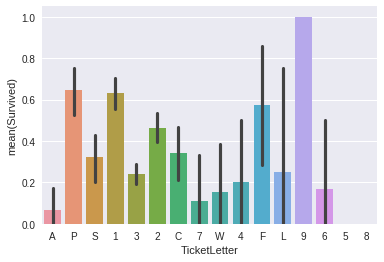

In [41]:
sns.barplot(x = 'TicketLetter', y='Survived', data=train)
df_count = train.groupby(['TicketLetter'],as_index=True)['PassengerId'].count().sort_values(ascending=False)
print(df_count)

In [42]:
def filter_ticket(x):
    if x in ['9', '8', '5', 'L', '6', 'F', '7', '4', 'W', 'A']:
        return 'Rare'
    elif x in ['C', 'P', 'S', '1']:
        return 'Frequent'
    elif x == '2':
        return 'Common'
    elif x == '3':
        return 'Commonest'

for df in [train, test]:
    df['TicketCategory'] = df['TicketLetter'].apply(filter_ticket)

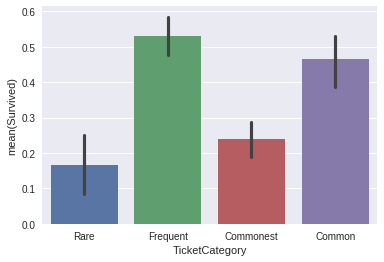

In [43]:
sns.barplot(x='TicketCategory', y='Survived', data=train)

In [44]:
def simplify_ticket(df):
    df = pd.get_dummies(df, columns=['TicketCategory'])
    df = df.drop(['TicketLetter', 'Ticket'], axis=1)
    return df

train,test = simplify_ticket(train), simplify_ticket(test)

In [45]:
train.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Age', u'SibSp', u'Parch',
       u'Fare', u'Embarked_C', u'Embarked_Q', u'Embarked_S', u'HasCabin',
       u'FamilySize_Big', u'FamilySize_Small', u'FamilySize_Solo',
       u'NameLength', u'Title_Master', u'Title_Miss', u'Title_Mr',
       u'Title_Mrs', u'Title_Rare_female', u'Title_Rare_male',
       u'TicketCategory_Common', u'TicketCategory_Commonest',
       u'TicketCategory_Frequent', u'TicketCategory_Rare'],
      dtype='object')

## Age:

We have seen that there are some missing values for the age. It is worthy to study its distribution:

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%             NaN
50%             NaN
75%             NaN
max       80.000000
Name: Age, dtype: float64

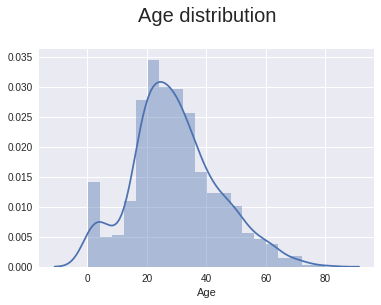

In [46]:
plt.title('Age distribution', size=20, y=1.1)
sns.distplot(train['Age'].dropna())
train['Age'].describe()

So the age is not that far from a Gaussian distribution. The median is 28 years, while the average is more like 29-30 years. 

Let's keep track of whether the age was missing or not with a binary value, and then we will fill the missing values.
We will fill the missing values generating a random number according to a Gaussian distribution.

**Note:** we must reflect the changes to the test data as well!

In [47]:
for df in [train, test]:
    df['MissingAge'] = df['Age'].apply(lambda x : 1 if np.isnan(x) else 0)

In [53]:
col_to_drop = ['PassengerId', 'Age', 'Survived', 'MissingAge']

from sklearn.metrics import mean_squared_error, r2_score

x_train_not_age_nan = train.loc[train['MissingAge'] == 0, :]

y_train_not_age_nan = x_train_not_age_nan['Age']

x_train_not_age_nan = x_train_not_age_nan.drop(col_to_drop, axis=1, errors='ignore')


In [54]:
rpart_params = {
    'criterion' : ['mse'],
    'splitter' : ['best'],
    'max_features' : ['auto', 'sqrt', 'log2', None],
    'max_depth' : [2, 3, 4],
    'min_samples_split' : [2, 3],
    'min_samples_leaf' : [1, 2],
    'max_leaf_nodes' : [3, 4, None],
    'random_state' : [RANDOM_SEED],
    'presort' : [True]
}

model = DecisionTreeRegressor()
age_grid = GridSearchCV(model, rpart_params, n_jobs=-1).fit(x_train_not_age_nan, y_train_not_age_nan.values.ravel())
print 'Best model CV score: ', age_grid.best_score_
age_estimator = age_grid.best_estimator_.fit(x_train_not_age_nan, y_train_not_age_nan.values.ravel())

Best model CV score:  0.383081877666


count    891.000000
mean      29.521038
std       13.498451
min        0.420000
25%       21.697674
50%       29.328244
75%       36.750000
max       80.000000
Name: Age, dtype: float64

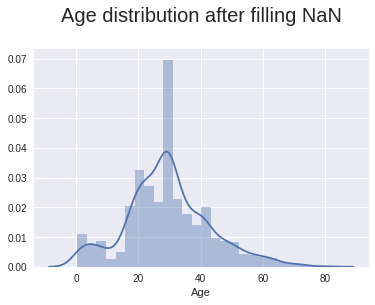

In [55]:
for df in [train, test]:
    age_fill = age_estimator.predict(df.loc[df['MissingAge'] == 1, :].drop(col_to_drop, axis=1, errors='ignore'))

    df.loc[df['MissingAge'] == 1, 'Age'] = age_fill

plt.title('Age distribution after filling NaN', size=20, y=1.1)
sns.distplot(train['Age'])
train['Age'].describe()

Ok, the mean is slightly changed but the distribution is quite the same.

To simplify the feature space, we will subdivide the age in 5 slots:

In [56]:
for df in [train, test]:
    df['Age'] = pd.cut(df['Age'], 5, labels=[0, 1, 2, 3, 4])

## Final refinements

The only final refinement is to drop the unused columns and convert the Sex column in a binary digit

In [60]:
train_y = train['Survived'].ravel()
train_x = train.drop(['Survived', 'PassengerId'], axis=1)

test_x = test.drop(['PassengerId'], axis=1)


for df in [train_x, test_x]:
    for col in df.columns:
        df[col] = df[col].astype('int')

We have all numerical features and hence we are ready to start with the model selection.

# Correlation between all features:

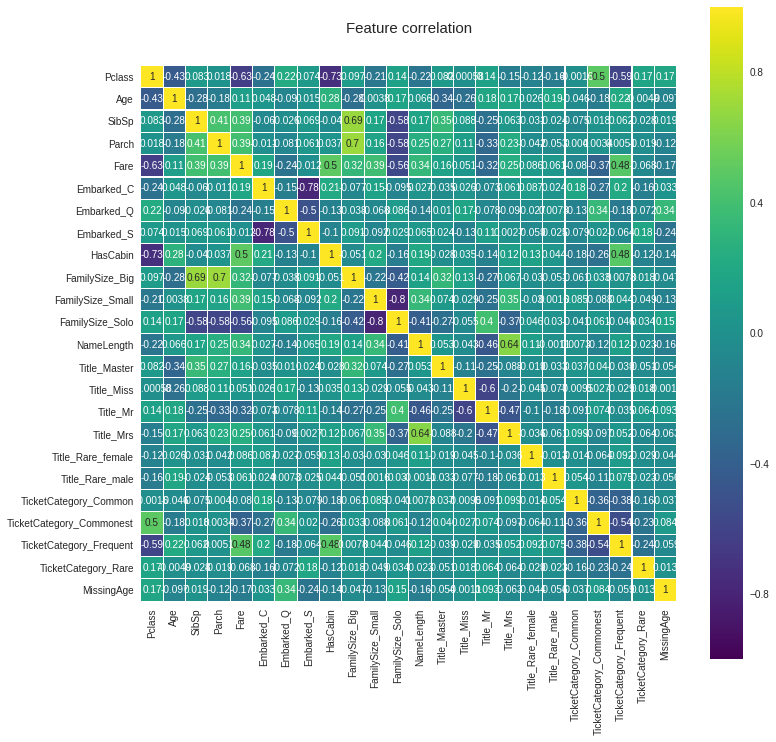

In [64]:
colormap = plt.cm.viridis
plt.figure(figsize=(12, 12))
plt.title("Feature correlation", y=1.05, size=15)
sns.heatmap(train_x.corr(), linewidths=0.1, square=True, vmax=1.0, annot=True, cmap=colormap)

<Container object of 24 artists>

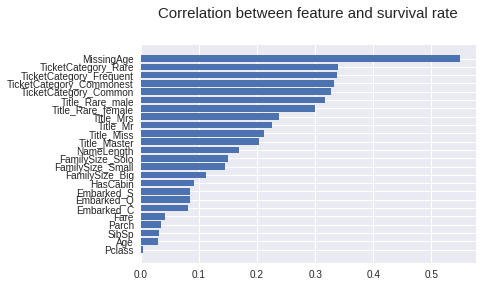

In [65]:
var_correlations = {c: np.abs(train['Survived'].corr(train_x[c])) for c in train_x.columns}

corr_dataframe = pd.DataFrame(var_correlations, index=['Correlation']).T.sort_values(by='Correlation')
plt.title('Correlation between feature and survival rate', y=1.1, size=15)
plt.barh(range(corr_dataframe.shape[0]), corr_dataframe['Correlation'].values, tick_label=train_x.columns.values)

# Creating the validation set

In [66]:
from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(train_x, train_y, test_size=0.3, random_state=RANDOM_SEED)
x_test = test_x.copy()

x_train.index = np.arange(len(x_train))
x_validation.index = np.arange(len(x_validation))

In [69]:
print x_train.shape
print x_validation.shape
print x_test.shape

(623, 24)
(268, 24)
(418, 24)


# Model selection

## Logistic regression

Logistic regression is the simplest classification method. To train the logistic regression, we will use a bunch of parameters and perform a grid search using a crossvalidation with the default 3 folds.

Original parameters are:

    lr_params = {
        'C' : [0.01, 0.03, 0.1, 0.3, 1, 2, 3],
        'fit_intercept' : [True, False],
        'max_iter' : [5000],
        'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
        'tol' : [1e-4],
        'random_state' : [RANDOM_SEED]
    }

In [75]:
lr_params = {
    'C' : [0.01, 0.03, 0.1, 0.3, 1, 3],
    'fit_intercept' : [True],
    'max_iter' : [5000],
    'solver' : ['newton-cg'],
    'tol' : [1e-4],
    'random_state' : [RANDOM_SEED]
}

log_regression = linear_model.LogisticRegression()
acc_scorer = make_scorer(accuracy_score)
log_reg_models = GridSearchCV(log_regression, lr_params, scoring=acc_scorer, n_jobs=-1)
log_reg_models = log_reg_models.fit(x_train, y_train)

lr_best = log_reg_models.best_estimator_
lr_best = lr_best.fit(x_train, y_train)

lr_model = {
    'Name' : 'Logistic regression', 
    'CVScore' : log_reg_models.best_score_, 
    'CVStd' : log_reg_models.cv_results_['std_test_score'][log_reg_models.best_index_],
    'Result_train' : lr_best.predict(x_train),
    'Result_test' : lr_best.predict(x_test),
    'Model' : lr_best
}

In [76]:
print ('Best model - avg:', 
      lr_model['CVScore'],
      '+/-', 
      lr_model['CVStd'])
print
print(log_reg_models.best_estimator_)

('Best model - avg:', 0.8202247191011236, '+/-', 0.013920306508350296)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=4321, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)


## Random forest classifier

Random forests are a powerful classification method, but require a discrete time to train. We will do the same thing as before, using cross validation to find the best model with a grid search over a bunch of different parameters

Originally written with these parameters:

    rf_params = {
        'n_estimators' :  [50, 100, 400, 700, 1000],
        'max_features' : ['log2', 'sqrt', 'auto'],
        'criterion' : ['entropy', 'gini'],
        'min_samples_split' :  [2, 4, 10, 12, 16],
        'min_samples_leaf' : [1, 5, 10],
        'random_state' : [RANDOM_SEED]
    }


Then shorted out to save time.

In [77]:
rf_params = {
    'n_estimators' :  [30, 50, 100, 400, 700, 1000],
    'max_features' : ['log2', 'sqrt', 'auto'],
    'criterion' : ['entropy', 'gini'],
    'min_samples_split' :  [2, 4, 10, 12, 16],
    'min_samples_leaf' : [1, 5, 10],
    'random_state' : [RANDOM_SEED]
}

random_forest = ensemble.RandomForestClassifier()
acc_scorer = make_scorer(accuracy_score)
rf_models = GridSearchCV(random_forest, rf_params, scoring=acc_scorer, n_jobs=-1)
rf_models = rf_models.fit(x_train, y_train)

rf_best = rf_models.best_estimator_
rf_best = rf_best.fit(x_train, y_train)

rf_model = {
    'Name' : 'Random forest', 
    'CVScore' : rf_models.best_score_, 
    'CVStd' : rf_models.cv_results_['std_test_score'][rf_models.best_index_],
    'Result_train' : rf_best.predict(x_train),
    'Result_test' : rf_best.predict(x_test),
    'Model' : rf_best
}

In [78]:
best_idx = rf_models.best_index_
print('Best model - avg:', 
      rf_model['CVScore'],
      '+/-', 
      rf_model['CVStd'])
print
print(rf_models.best_estimator_)

('Best model - avg:', 0.81380417335473521, '+/-', 0.016056509565044674)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=16, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=4321,
            verbose=0, warm_start=False)


<Container object of 24 artists>

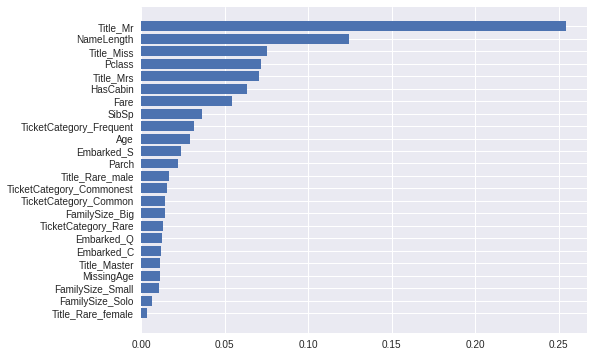

In [83]:
feature_importances = [(x, y) for x,y in zip(rf_best.feature_importances_, x_train.columns.values)]

feature_importances.sort(key = lambda x : x[0])
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_importances)), [x[0] for x in feature_importances], tick_label = [x[1] for x in feature_importances])

XGBoost classifier
--

This is a very good general purpose classifier. The training process will take about 1 minute.

Originally with this parameters:

    xgb_params = {
        'max_depth' : [2, 3, 4, 5, 6],
        'learning_rate' : [0.05, 0.01, 0.005],
        'n_estimators' : [100, 300, 600],
        'seed' : [RANDOM_SEED]
    }

In [85]:
xgb_params = {
    'max_depth' : [2, 3, 4, 5, 6],
    'learning_rate' : [0.05, 0.01, 0.005],
    'n_estimators' : [100, 300, 600],
    'seed' : [RANDOM_SEED]
}

xgb_model = xgb.XGBClassifier()
acc_scorer = make_scorer(accuracy_score)
xgb_grid = GridSearchCV(xgb_model, xgb_params, scoring=acc_scorer)
xgb_grid = xgb_grid.fit(x_train, y_train)

xgb_best = xgb_grid.best_estimator_
xgb_best = xgb_best.fit(x_train, y_train)

xgb_model = {
    'Name' : 'XGBoost', 
    'CVScore' : xgb_grid.best_score_, 
    'CVStd' : xgb_grid.cv_results_['std_test_score'][xgb_grid.best_index_],
    'Result_train' : xgb_best.predict(x_train),
    'Result_test' : xgb_best.predict(x_test),
    'Model' : xgb_best
}

In [86]:
best_idx = xgb_grid.best_index_
print('Best model - avg:', 
      xgb_model['CVScore'],
      '+/-', 
      xgb_model['CVStd'])
print
print(xgb_grid.best_estimator_)

('Best model - avg:', 0.8170144462279294, '+/-', 0.004664954554159776)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=4321, silent=True, subsample=1)


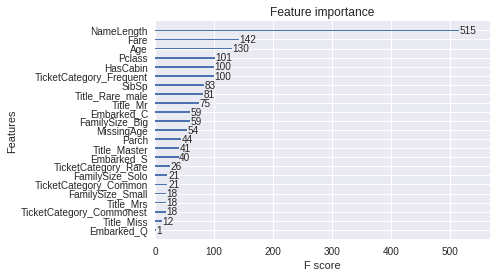

In [87]:
xgb.plot_importance(xgb_best)

## Support vector classifier

SVC are also very good classifier, but requires a normalization phase in order to converge.

In [88]:
train_test = pd.concat([x_train, x_test, x_validation], ignore_index=True)
train_test_normalized = preprocessing.scale(train_test)
x_train_normalized = train_test_normalized[:len(x_train), :]
x_test_normalized = train_test_normalized[len(x_train):len(x_train) + len(x_test), :]
x_validation_normalized = train_test_normalized[len(x_train) + len(x_test):, :]

And now for the training

    svm_params = {
        'C' : [0.1, 0.3, 0.8, 0.9, 1.0, 2.0],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'tol' : [1e-3, 1e-4],
        'degree' : [2, 3, 4, 5],
        'random_state' : [RANDOM_SEED]
    }

In [89]:
svm_params = {
    'C' : [0.1, 0.3, 0.8, 0.9, 1.0, 2.0],
    'kernel' : ['linear', 'rbf', 'sigmoid'],
    'tol' : [1e-3, 1e-4],
    'degree' : [2, 3, 4, 5],
    'random_state' : [RANDOM_SEED]
}
acc_scorer = make_scorer(accuracy_score)
svc = SVC()
svc_classifiers = GridSearchCV(svc, svm_params, scoring=acc_scorer, n_jobs=-1)
svc_classifiers = svc_classifiers.fit(x_train_normalized, y_train)

svc_best = svc_classifiers.best_estimator_
svc_best = svc_best.fit(x_train_normalized, y_train)

svc_model = {
    'Name' : 'SVC', 
    'CVScore' : svc_classifiers.best_score_, 
    'CVStd' : svc_classifiers.cv_results_['std_test_score'][svc_classifiers.best_index_],
    'Result_train' : svc_best.predict(x_train_normalized),
    'Result_test' : svc_best.predict(x_test_normalized),
    'Model' : svc_best
}

In [91]:
best_idx = svc_classifiers.best_index_
print('Best model - avg:', 
      svc_model['CVScore'], 
      '+/-', 
      svc_model['CVStd'])
print
print(svc_classifiers.best_estimator_)

('Best model - avg:', 0.8170144462279294, '+/-', 0.020872704844516549)

SVC(C=0.3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=4321, shrinking=True,
  tol=0.001, verbose=False)


# Ada boost

Also here, the parameters were:

    ada_params = {
        'n_estimators' : [20, 50, 100, 500, 1000],
        'learning_rate' : [0.1, 0.4, 0.3, 0.9, 1],
        'algorithm' : ['SAMME', 'SAMME.R'],
        'random_state' : [RANDOM_SEED]
    }

In [92]:
ada_params = {
    'n_estimators' : [20, 50, 100, 500],
    'learning_rate' : [0.1, 0.4, 0.3, 0.9, 1],
    'algorithm' : ['SAMME', 'SAMME.R'],
    'random_state' : [RANDOM_SEED]
}

acc_scorer = make_scorer(accuracy_score)
ada_class = ensemble.AdaBoostClassifier()
ada_classifiers = GridSearchCV(ada_class, ada_params, scoring=acc_scorer, n_jobs=-1)
ada_classifiers = ada_classifiers.fit(x_train, y_train)

ada_best = ada_classifiers.best_estimator_
ada_best = ada_best.fit(x_train, y_train)

ada_model = {
    'Name' : 'Ada boost', 
    'CVScore' : ada_classifiers.best_score_, 
    'CVStd' : ada_classifiers.cv_results_['std_test_score'][ada_classifiers.best_index_],
    'Result_train' : ada_best.predict(x_train),
    'Result_test' : ada_best.predict(x_test),
    'Model' : ada_best
}

In [94]:
best_idx = ada_classifiers.best_index_
print('Best model - avg:', 
      ada_model['CVScore'], 
      '+/-', 
      ada_model['CVStd'])
print
print(ada_classifiers.best_estimator_)

('Best model - avg:', 0.8250401284109149, '+/-', 0.0095078322887972039)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=4321)


# Ensemble

We have seen that overall the XGBClassifier is the one that performs the best.

In [95]:
class Ensemble:
    def __init__(self, models, svc_last=True):
        self.models = models[:]
        self.svc_last = svc_last
    
    def fit(self, X_train, y_train, X_train_normalized):
        fitted_models = [m['Model'].fit(X_train, y_train) for m in self.models]
        for i in range(len(fitted_models)):
            self.models[i]['Model'] = fitted_models[i]
    
    def predict(self, X_test, X_test_normalized):
        predictions = []
        for m in self.models:
            if m['Name'] == 'SVC':
                predictions.append(m['Model'].predict(X_test_normalized))
            else:
                predictions.append(m['Model'].predict(X_test))
        
        df = pd.DataFrame(np.array(predictions), index=[m['Name'] for m in self.models])
        
        return df.apply(lambda x : 0 if np.sum(x) <= 2 else 1)

    def __repr__(self):
        return "Ensemble(" + ', '.join([m['Name'] for m in self.models]) + ")"

In [96]:
ens = Ensemble([rf_model, ada_model, xgb_model, lr_model, svc_model])
predictions = ens.predict(x_test, x_test_normalized).values

In [97]:
ensemble_model = {
    'Name' : 'Ensemble', 
    'CVScore' : 0, 
    'CVStd' : 0,
    'Result_train' : [],
    'Result_test' : predictions,
    'Model' : ens
}

answer_df = pd.DataFrame()
answer_df['PassengerId'] = test['PassengerId']
answer_df['Survived'] = predictions

answer_df.to_csv('results_ensemble.csv', index=False)

# Stacking

In [99]:
def get_stacked(x, x_normalized, models):
    predictions = []
    for m in models:
        if m['Name'] == 'SVC':
            predictions.append(m['Model'].predict(x_normalized))
        else:
            predictions.append(m['Model'].predict(x))
    stack = pd.DataFrame(np.array(predictions).T, columns=[m['Name'] for m in models])
    return pd.concat([x, stack], axis=1)

stacking_models = [rf_model, ada_model, svc_model]
train_stacked = get_stacked(x_train, x_train_normalized, stacking_models)
test_stacked = get_stacked(x_test, x_test_normalized, stacking_models)

These are the initial parameters I used for GridSearch:

    xgb_params = {
        'max_depth' : [2, 3, 4, 5, 6],
        'learning_rate' : [0.05, 0.01],
        'n_estimators' : [30, 100, 300, 600],
        'seed' : [RANDOM_SEED]
    }

In [101]:
xgb_params = {
    'max_depth' : [2, 3, 4, 5, 6],
    'learning_rate' : [0.05, 0.01],
    'n_estimators' : [30],
    'seed' : [RANDOM_SEED]
}

xgb_stacked = xgb.XGBClassifier()
acc_scorer = make_scorer(accuracy_score)
xgb_stacked_grid = GridSearchCV(xgb_stacked, xgb_params, scoring=acc_scorer)
xgb_stacked_grid = xgb_stacked_grid.fit(train_stacked, y_train)

stacked_best = xgb_stacked_grid.best_estimator_.fit(train_stacked, y_train)

stacked_model = {
    'Name' : 'Stacking', 
    'CVScore' : xgb_stacked_grid.best_score_, 
    'CVStd' : xgb_stacked_grid.cv_results_['std_test_score'][xgb_stacked_grid.best_index_],
    'Result_train' : xgb_stacked_grid.predict(train_stacked),
    'Result_test' : xgb_stacked_grid.predict(test_stacked),
    'Model' : stacked_best
}

In [102]:
print('Best model - avg:', 
      stacked_model['CVScore'], 
      '+/-', 
      stacked_model['CVStd'])
print
print(stacked_best)

('Best model - avg:', 0.8780096308186196, '+/-', 0.019648138757640408)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=30, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=4321, silent=True, subsample=1)


# Check the validation

In [104]:
models = [lr_model, rf_model, ada_model, xgb_model, svc_model, ensemble_model, stacked_model]
models_df = pd.DataFrame(models, index=[m['Name'] for m in models])

In [105]:
x_validation_stacked = get_stacked(x_validation, x_validation_normalized, stacking_models)

def get_validation_predictions(x):
    if x['Name'] == 'SVC':
        return x['Model'].predict(x_validation_normalized)
    elif x['Name'] == 'Ensemble':
        return x['Model'].predict(x_validation, x_validation_normalized)
    elif x['Name'] == 'Stacking':
        return x['Model'].predict(x_validation_stacked)
    else:
        return x['Model'].predict(x_validation)

models_df['ValidationScore'] = models_df.apply(lambda x : accuracy_score(get_validation_predictions(x), y_validation), axis=1)

models_df['ValidationScore']

Logistic regression    0.835821
Random forest          0.847015
Ada boost              0.813433
XGBoost                0.850746
SVC                    0.861940
Ensemble               0.847015
Stacking               0.847015
Name: ValidationScore, dtype: float64

# Result output

Overall, it seems that the SVC generalizes better, so we will use that SVC to output the result. 

Note that here a statistical test should be carried out, because the accuracy alone is usually not enough. One should use cross validation instead of holdout and see if there is a statistical significance of a given model over the others.

In [106]:
best_model = svc_model['Model']
best_model = best_model.fit(np.concatenate([x_train_normalized, x_validation_normalized]), np.concatenate([y_train, y_validation]))

predictions = best_model.predict(x_test_normalized)

result = pd.DataFrame()
result['PassengerId'] = test['PassengerId']
result['Survived'] = predictions

result.to_csv('results.csv', index=False)

# References

- [Titanic Random Forest: 82.78%](https://www.kaggle.com/zlatankr/titanic/titanic-random-forest-82-78/run/806902)
- [Scikit-Learn ML from Start to Finish](https://www.kaggle.com/jeffd23/titanic/scikit-learn-ml-from-start-to-finish/run/320209)
- [A Journey through Titanic](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/run/447794)